Everything on CPU

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# from utils import *

import warnings
warnings.filterwarnings("ignore")

In [130]:
tf.__version__

'2.15.0'

In [131]:
tf.random.set_seed(2024)

In [132]:
tukey = pd.read_pickle('data/tukey_estimates.pkl')
excess_returns = pd.read_pickle('data/exc_returns.pkl')
index_returns = pd.read_pickle('data/index_returns.pkl')
stocks_returns = pd.read_pickle('data/stocks_returns.pkl')

In [133]:
LOOK_BACK = 15
n_features = len(tukey.columns)
FORECAST_RANGE = 1

We want to start wit hthe first obsrvation of the actual test set (the whole 2018 year). However our model expect as input the previous 15 observations to perform a prediction. We need to "add" the last 15 observatin of the training set to the testing set.  

In [134]:
starting_date_test = tukey.loc[:'2017-01-02'].index[-(LOOK_BACK+1)]
starting_date_test

Timestamp('2016-12-08 00:00:00')

In [135]:
train_price, test_price = tukey.loc[:'2017-01-02'], tukey.loc[starting_date_test:]

In [136]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_price)
scaled_test = scaler.transform(test_price)

In [137]:
# alternative to keras' TimeSeriesGenerator
def split_sequence(sequence, look_back, forecast_horizon):
 X, y = list(), list()
 for i in range(len(sequence)): 
   lag_end = i + look_back
   forecast_end = lag_end + forecast_horizon
   if forecast_end > len(sequence):
     break
   seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
   X.append(seq_x)
   y.append(seq_y)
 return np.array(X), np.array(y)

In [138]:
X_train, y_train = split_sequence(scaled_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = split_sequence(scaled_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1001, 15, 41)
(1001, 1, 41)
(254, 15, 41)
(254, 1, 41)


### SIMPLE LSTM

In [139]:
model_enc_dec = Sequential()
model_enc_dec.add(LSTM(100, activation='relu', input_shape=(LOOK_BACK, n_features)))
model_enc_dec.add(RepeatVector(FORECAST_RANGE))
model_enc_dec.add(LSTM(100, activation='relu', return_sequences=True))
model_enc_dec.add(TimeDistributed(Dense(n_features)))
model_enc_dec.compile(optimizer='adam', loss='mse')
# plot_model(model=model_enc_dec, show_shapes=True)

In [140]:
plot_model(model=model_enc_dec, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [141]:
history = model_enc_dec.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50


32/32 [==============================] - 3s 10ms/step - loss: 0.1428
Epoch 2/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0240
Epoch 3/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0124
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0087
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0063
Epoch 6/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0051
Epoch 7/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0045
Epoch 8/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0040
Epoch 9/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0035
Epoch 10/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0032
Epoch 11/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0030
Epoch 12/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0028
Epoch 13/50
32/32 [==============================] - 0

In [142]:
yhat = model_enc_dec.predict(X_test, verbose=0)

In [143]:
def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse

In [144]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [145]:
def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse,yhat_inverse)
    print('mae:', mae.numpy())
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse.numpy())
    mape = mape_(y_test_inverse,yhat_inverse)
    print('mape:', mape.numpy())

In [146]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 4.5376663
mse: 64.71871
mape: 7.991799


In [147]:
yhat_inverse.shape, y_test_inverse.shape

((254, 41), (254, 41))

In [148]:
metrics_df = pd.DataFrame(columns=['Stock', 'MAE', 'MSE', 'MAPE'])
mse_ = tf.keras.losses.MeanSquaredError()
mae_ = tf.keras.losses.MeanAbsoluteError()
mape_ = tf.keras.losses.MeanAbsolutePercentageError()

for stock in range(y_test_inverse.shape[1]):
    stock_name = tukey.iloc[:, stock].name
    mae = mae_(y_test_inverse[:, stock], yhat_inverse[:, stock])
    mse = mse_(y_test_inverse[:, stock], yhat_inverse[:, stock])
    mape = mape_(y_test_inverse[:, stock], yhat_inverse[:, stock])

    metrics_df = metrics_df.append({'Stock': stock_name, 'MAE': mae.numpy(), 'MSE': mse.numpy(), 'MAPE': mape.numpy()}, ignore_index=True)

In [149]:
metrics_df

,Stock,MAE,MSE,MAPE
0,VOW3 GY Equity,12.460572,289.810852,9.534580
1,ENGI FP Equity,1.302996,2.150386,9.499865
2,BAYN GY Equity,9.823684,137.385620,8.845063
3,BNP FP Equity,2.323351,7.730745,3.758851
4,PHIA NA Equity,0.843784,1.010078,2.915060
5,ISP IM Equity,0.230561,0.067894,8.408731
6,SAN FP Equity,5.696884,42.679440,6.849889
7,MC FP Equity,4.887407,33.181587,2.190891
8,ENEL IM Equity,0.400749,0.273339,7.910131
9,CS FP Equity,0.498157,0.350429,2.056236


In [150]:
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

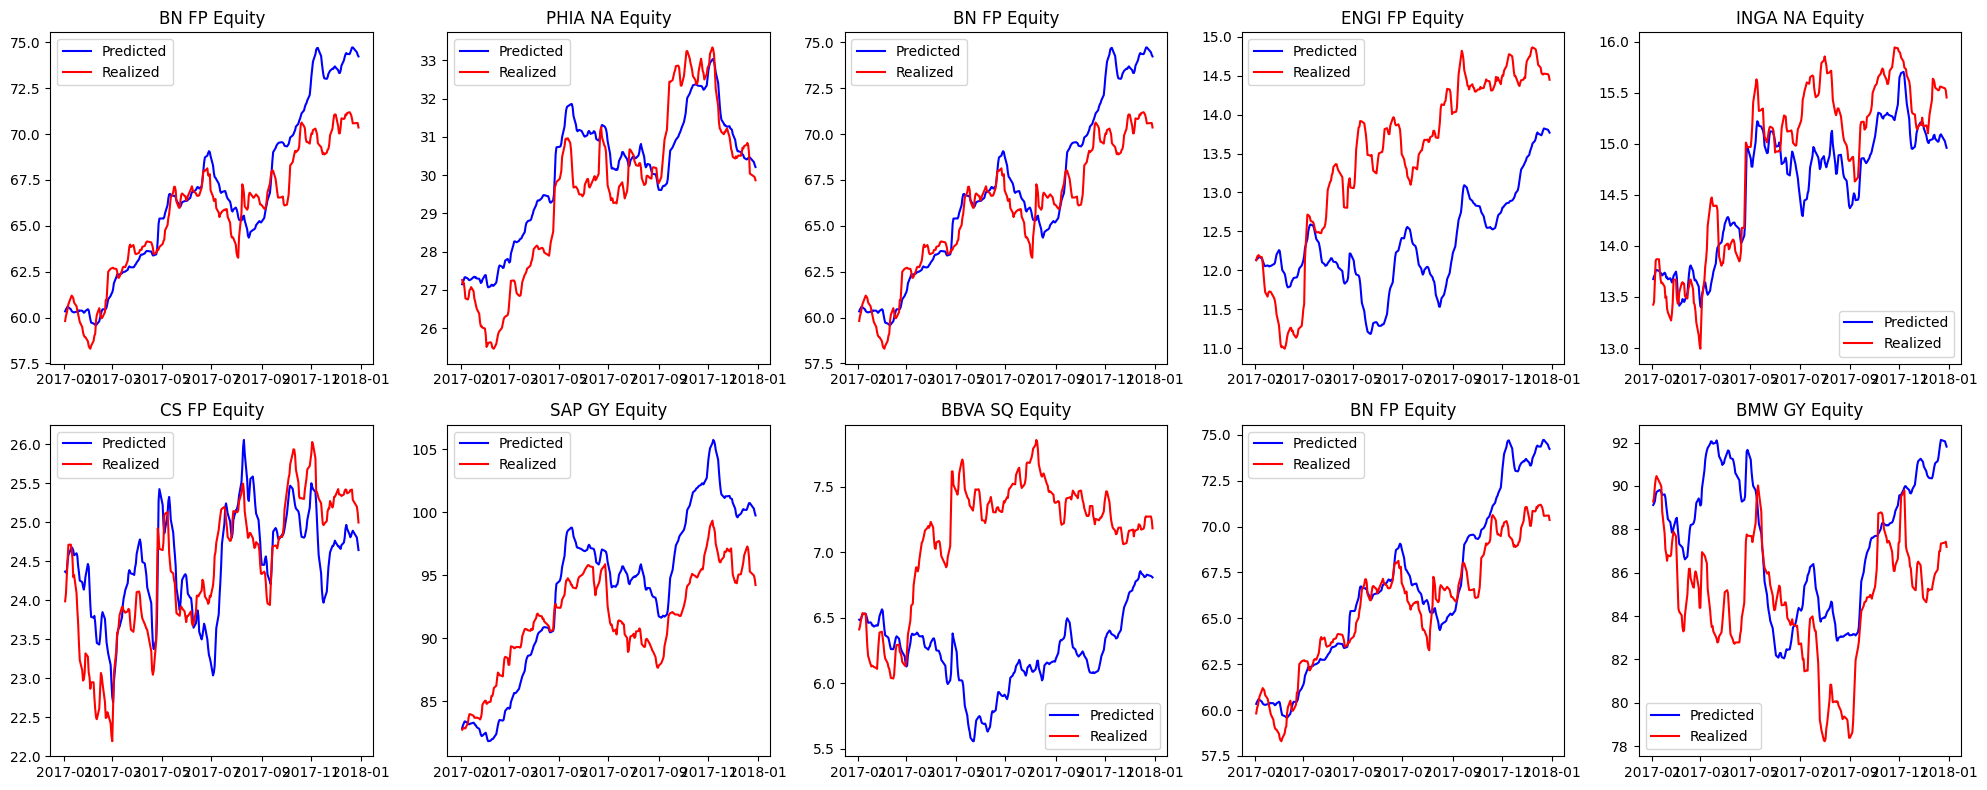

In [151]:
rand = np.random.randint(0, 41, 10)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, stock in enumerate(rand):
    row = i // 5
    col = i % 5
    axs[row, col].plot(yhat_inverse_df.iloc[:, stock], color='blue', label='Predicted')
    axs[row, col].plot(y_test_inverse_df.iloc[:, stock], color='red', label='Realized')
    axs[row, col].legend()
    axs[row, col].set_title(yhat_inverse_df.iloc[:, stock].name)

plt.tight_layout()
plt.show()

### CNN-LSTM

In [152]:
cnn_lstm = Sequential()
cnn_lstm.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(LOOK_BACK, n_features)))
cnn_lstm.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_lstm.add(MaxPooling1D(pool_size=2))
cnn_lstm.add(Flatten())
cnn_lstm.add(RepeatVector(FORECAST_RANGE))
cnn_lstm.add(LSTM(200, activation='relu', return_sequences=True))
cnn_lstm.add(TimeDistributed(Dense(100, activation='relu')))
cnn_lstm.add(TimeDistributed(Dense(n_features)))
cnn_lstm.compile(loss='mse', optimizer='adam')

In [153]:
history = cnn_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
32/32 [==============================] - 2s 6ms/step - loss: 0.1005
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0208
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0143
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0125
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0103
Epoch 6/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0087
Epoch 7/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0075
Epoch 8/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0069
Epoch 9/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0062
Epoch 10/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0054
Epoch 11/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0051
Epoch 12/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 13/50
32/32 [==============================

In [154]:
yhat = cnn_lstm.predict(X_test, verbose=0)

In [155]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [156]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 4.1698112
mse: 54.48684
mape: 7.0044713


In [157]:
yhat_inverse.shape, y_test_inverse.shape

((254, 41), (254, 41))

In [158]:
metrics_df = pd.DataFrame(columns=['Stock', 'MAE', 'MSE', 'MAPE'])

for stock in range(y_test_inverse.shape[1]):
    stock_name = tukey.iloc[:, stock].name
    mae = mae_(y_test_inverse[:, stock], yhat_inverse[:, stock])
    mse = mse_(y_test_inverse[:, stock], yhat_inverse[:, stock])
    mape = mape_(y_test_inverse[:, stock], yhat_inverse[:, stock])

    metrics_df = metrics_df.append({'Stock': stock_name, 'MAE': mae.numpy(), 'MSE': mse.numpy(), 'MAPE': mape.numpy()}, ignore_index=True)

In [159]:
metrics_df

,Stock,MAE,MSE,MAPE
0,VOW3 GY Equity,6.976908,61.232300,5.700531
1,ENGI FP Equity,1.095003,1.490960,7.965329
2,BAYN GY Equity,5.449972,42.789078,4.961788
3,BNP FP Equity,4.356201,26.254313,6.917390
4,PHIA NA Equity,1.297965,2.573249,4.356413
5,ISP IM Equity,0.192739,0.049721,7.051799
6,SAN FP Equity,4.295864,25.858532,5.236829
7,MC FP Equity,25.840221,838.762268,11.279011
8,ENEL IM Equity,0.482946,0.337366,9.695479
9,CS FP Equity,1.537787,2.836693,6.307991


In [160]:
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

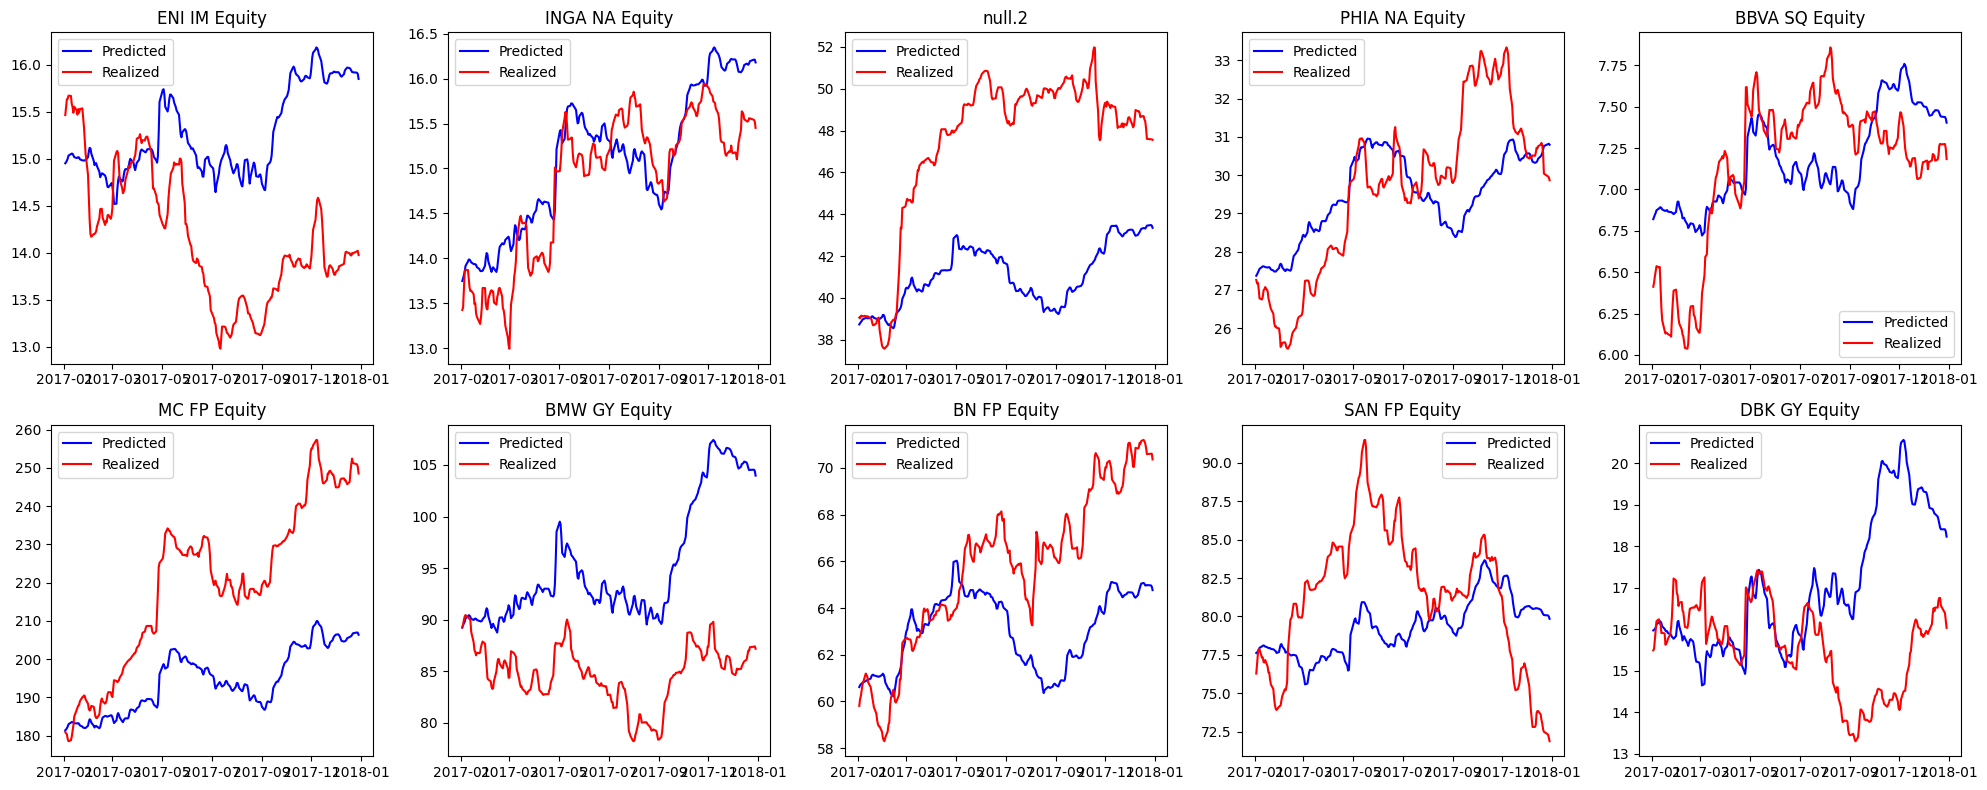

In [161]:
rand = np.random.randint(0, 41, 10)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, stock in enumerate(rand):
    row = i // 5
    col = i % 5
    axs[row, col].plot(yhat_inverse_df.iloc[:, stock], color='blue', label='Predicted')
    axs[row, col].plot(y_test_inverse_df.iloc[:, stock], color='red', label='Realized')
    axs[row, col].legend()
    axs[row, col].set_title(yhat_inverse_df.iloc[:, stock].name)

plt.tight_layout()
plt.show()

### Multi-Head CNN-LSTM

In [162]:
input_layer = Input(shape=(LOOK_BACK, n_features)) 
head_list = []
# 41 "heads", each to extract feats from each ts
for i in range(0, n_features):
    conv_layer_head = Conv1D(filters=4, kernel_size=7, activation='relu')(input_layer)
    conv_layer_head_2 = Conv1D(filters=6, kernel_size=5, activation='relu')(conv_layer_head)
    conv_layer_flatten = Flatten()(conv_layer_head_2)
    head_list.append(conv_layer_flatten)
 
concat_cnn = Concatenate(axis=1)(head_list)
reshape = Reshape((head_list[0].shape[1], n_features))(concat_cnn)
lstm = LSTM(100, activation='relu')(reshape)
repeat = RepeatVector(FORECAST_RANGE)(lstm)
lstm_2 = LSTM(100, activation='relu', return_sequences=True)(repeat)
dropout = Dropout(0.2)(lstm_2)
dense = Dense(n_features, activation='linear')(dropout)
multi_head_cnn_lstm_model = Model(inputs=input_layer, outputs=dense)

multi_head_cnn_lstm_model.compile(loss='mse', optimizer='adam')

In [163]:
history = multi_head_cnn_lstm_model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
32/32 [==============================] - 19s 29ms/step - loss: 0.2261
Epoch 2/50
32/32 [==============================] - 1s 28ms/step - loss: 0.0644
Epoch 3/50
32/32 [==============================] - 1s 29ms/step - loss: 0.0464
Epoch 4/50
32/32 [==============================] - 1s 29ms/step - loss: 0.0324
Epoch 5/50
32/32 [==============================] - 1s 31ms/step - loss: 0.0270
Epoch 6/50
32/32 [==============================] - 1s 30ms/step - loss: 0.0250
Epoch 7/50
32/32 [==============================] - 1s 30ms/step - loss: 0.0229
Epoch 8/50
32/32 [==============================] - 1s 37ms/step - loss: 0.0215
Epoch 9/50
32/32 [==============================] - 1s 38ms/step - loss: 0.0203
Epoch 10/50
32/32 [==============================] - 1s 39ms/step - loss: 0.0189
Epoch 11/50
32/32 [==============================] - 1s 34ms/step - loss: 0.0177
Epoch 12/50
32/32 [==============================] - 1s 35ms/step - loss: 0.0169
Epoch 13/50
32/32 [=================

In [164]:
yhat = multi_head_cnn_lstm_model.predict(X_test, verbose=0)

In [165]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [166]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 4.442877
mse: 63.26078
mape: 7.6912427


In [167]:
metrics_df = pd.DataFrame(columns=['Stock', 'MAE', 'MSE', 'MAPE'])

for stock in range(y_test_inverse.shape[1]):
    stock_name = tukey.iloc[:, stock].name
    mae = mae_(y_test_inverse[:, stock], yhat_inverse[:, stock])
    mse = mse_(y_test_inverse[:, stock], yhat_inverse[:, stock])
    mape = mape_(y_test_inverse[:, stock], yhat_inverse[:, stock])

    metrics_df = metrics_df.append({'Stock': stock_name, 'MAE': mae.numpy(), 'MSE': mse.numpy(), 'MAPE': mape.numpy()}, ignore_index=True)

In [168]:
metrics_df

,Stock,MAE,MSE,MAPE
0,VOW3 GY Equity,6.554538,58.927563,5.313539
1,ENGI FP Equity,1.754411,3.656589,12.783734
2,BAYN GY Equity,14.610273,249.894821,13.276991
3,BNP FP Equity,3.680262,19.080183,5.883025
4,PHIA NA Equity,1.085755,1.730421,3.752041
5,ISP IM Equity,0.368856,0.177757,13.276874
6,SAN FP Equity,5.657492,40.572136,6.812563
7,MC FP Equity,25.935165,862.399109,11.305143
8,ENEL IM Equity,0.481260,0.364438,9.517384
9,CS FP Equity,0.718060,0.904148,2.995302


In [169]:
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

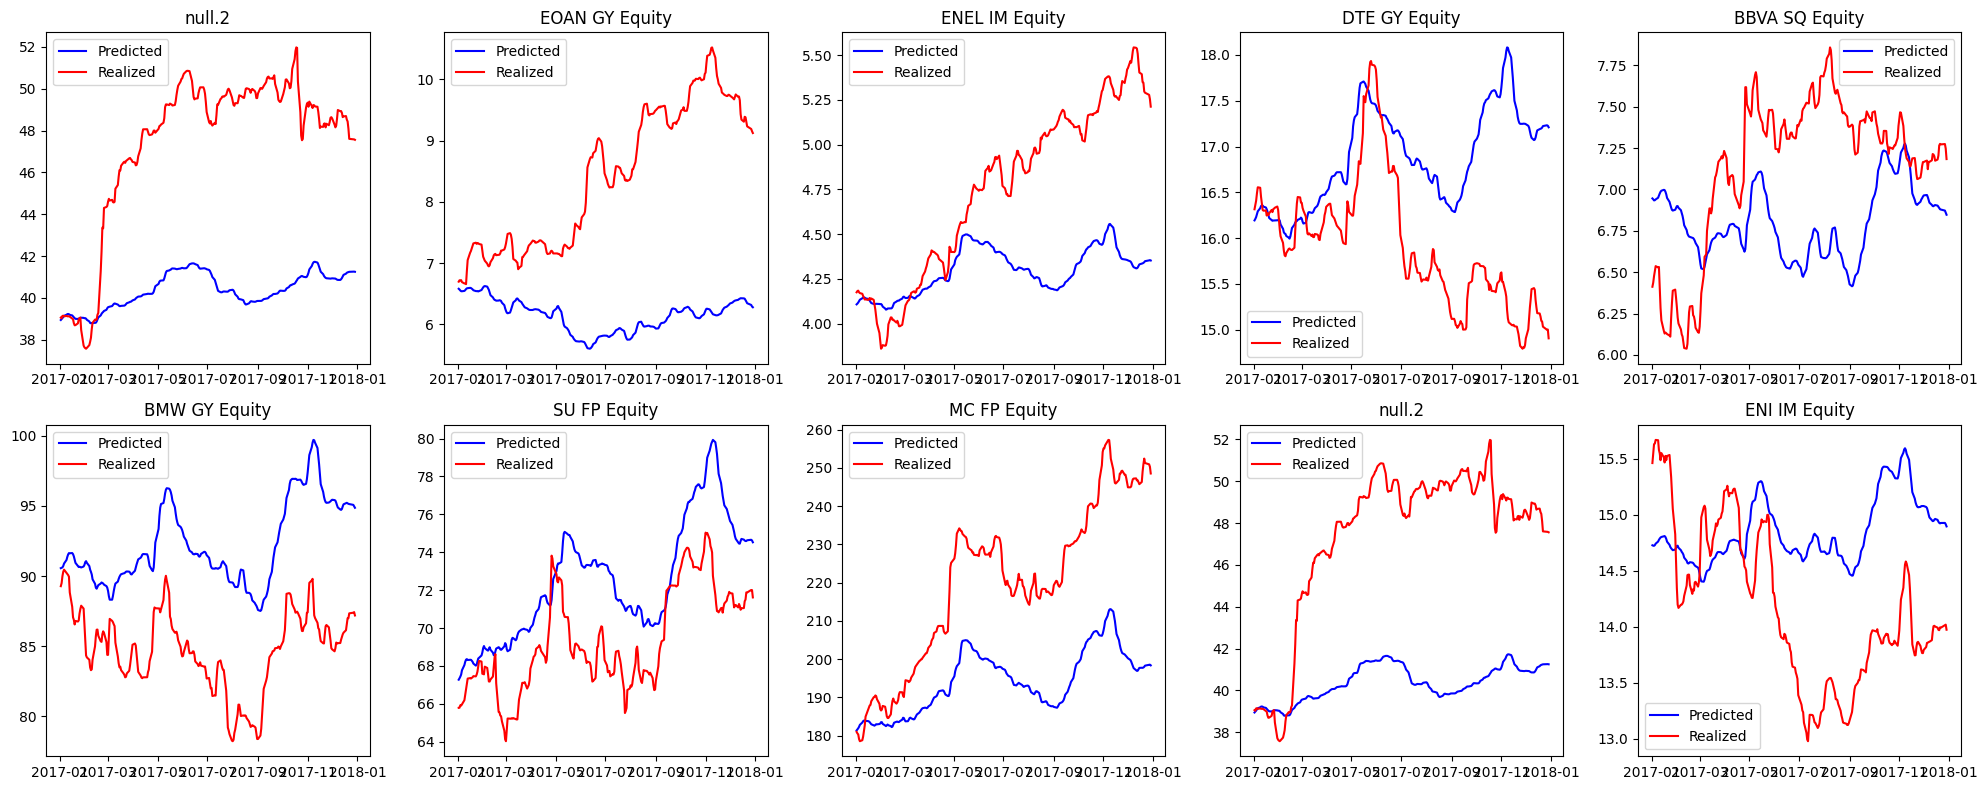

In [170]:
rand = np.random.randint(0, 41, 10)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, stock in enumerate(rand):
    row = i // 5
    col = i % 5
    axs[row, col].plot(yhat_inverse_df.iloc[:, stock], color='blue', label='Predicted')
    axs[row, col].plot(y_test_inverse_df.iloc[:, stock], color='red', label='Realized')
    axs[row, col].legend()
    axs[row, col].set_title(yhat_inverse_df.iloc[:, stock].name)

plt.tight_layout()
plt.show()

### CNN-BiLSTM

In [ ]:
# cnn_bilstm

In [ ]:
history = cnn_bilstm.fit(X_train, y_train, epochs=50, batch_size=32)

In [ ]:
yhat = cnn_bilstm.predict(X_test, verbose=0)

In [ ]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [ ]:
evaluate_forecast(y_test_inverse, yhat_inverse)

In [ ]:
metrics_df = pd.DataFrame(columns=['Stock', 'MAE', 'MSE', 'MAPE'])

for stock in range(y_test_inverse.shape[1]):
    stock_name = tukey.iloc[:, stock].name
    mae = mae_(y_test_inverse[:, stock], yhat_inverse[:, stock])
    mse = mse_(y_test_inverse[:, stock], yhat_inverse[:, stock])
    mape = mape_(y_test_inverse[:, stock], yhat_inverse[:, stock])

    metrics_df = metrics_df.append({'Stock': stock_name, 'MAE': mae.numpy(), 'MSE': mse.numpy(), 'MAPE': mape.numpy()}, ignore_index=True)

In [ ]:
metrics_df

In [ ]:
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

In [ ]:
rand = np.random.randint(0, 41, 10)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, stock in enumerate(rand):
    row = i // 5
    col = i % 5
    axs[row, col].plot(yhat_inverse_df.iloc[:, stock], color='blue', label='Predicted')
    axs[row, col].plot(y_test_inverse_df.iloc[:, stock], color='red', label='Realized')
    axs[row, col].legend()
    axs[row, col].set_title(yhat_inverse_df.iloc[:, stock].name)

plt.tight_layout()
plt.show()

----------------

### DO NOT CONSIDER CODE BELOW

In [43]:
portfolios_LSTM = get_ranking(yhat_inverse, N = [5, 7, 10], prices=True)
 
tot_performance_LSTM, portfolio_series_LSTM = calc_portfolios(portfolios_LSTM, stocks_returns.loc[yhat_inverse.index[0]:])


tot_performance_LSTM['Index performance'] = (1 + index_returns.loc[yhat_inverse.index[0]:]).prod() - 1 
tot_performance_LSTM

NameError: name 'get_ranking' is not defined

In [ ]:
# TOP 5 PORTFOLIO (best one in terms of cumulative return)
# mean returns, mean std and sharpe ratio (hyp : zero risk free rate)
portfolio_series_LSTM['Top5 series'].mean(), portfolio_series_LSTM['Top5 series'].std(), portfolio_series_LSTM['Top5 series'].mean()/portfolio_series_LSTM['Top5 series'].std() * 100

(0.002940179023940558, 0.0537965213225773, 5.465370160852064)

In [ ]:
# INDEX 
# mean returns, mean std and sharpe ratio (hyp : zero risk free rate)

index_returns.loc[yhat_inverse.index[0]:].mean(), index_returns.loc[yhat_inverse.index[0]:].std(), index_returns.loc[yhat_inverse.index[0]:].mean()/index_returns.loc[yhat_inverse.index[0]:].std() * 100

(0.0003492689328041595, 0.00626025876636661, 5.5791453011593575)

In [ ]:
plot_portfolios(portfolio_series_LSTM, index_returns.loc[yhat_inverse.index[0]:])

--------------